# Real time Emotion Detection on Video - Overlay

In [1]:
import numpy as np
from keras.models import model_from_json, load_model
import face_recognition
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
plt.style.use('ggplot')
from tqdm import tqdm


/anaconda3/envs/kerasv6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Part I. Load pretrained Keras models

### Introduction

The emotion recognition model has been trained using the FRET2003 dataset. This dataset consists of 28,709 grayscale images. Each image is categorized each based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The gender recognition model has been trained using the 'Faces in The Wild' dataset. The gender was infered by the name of the celebrity. The final weakly labelized dataset of approximatelly 250K was used to train the model.

### 1.1 - Gender recognition model

In [2]:
gender_model = load_model('./Trained Model/trained_GenderNet.hdf5')

### 1.2 Emotion recognition model

In [3]:
# load json and create model
json_file = open('./Trained Model/face_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Trained Model/face_model.h5")
print("Loaded model from disk")

emotion_model = loaded_model

Loaded model from disk


## Part II. Functions

In [4]:
def emotion_decoder(net_output, threshold = 0.3):
    '''EmotionNet output decoder.
    
    '''
    # Check if probability is higher than threshold
    if np.max(net_output) >= threshold:
        probability = str(np.max(net_output))
        if (np.argmax(net_output) == 0):
            prediction = 'Angry'
        elif (np.argmax(net_output) == 1):
            prediction = 'Disgust'
        elif (np.argmax(net_output) == 2):
            prediction = 'Fear'
        elif (np.argmax(net_output) == 3):
            prediction = 'Happy'
        elif (np.argmax(net_output) == 4):
            prediction = 'Sad'
        elif (np.argmax(net_output) == 5):
            prediction = 'Surprise'
        else:
            prediction = 'Neutral'
    else:
        # Do not label the box if you are not sure
        prediction = ''
        probability = ''
    return prediction + ' ' + probability[:5]
       
    
def gender_decoder(net_output, threshold=0.65):
    '''GenderNet label decoder -----------------------

    0: male
    1: female
    threshold: Probability minimum threshold to assign a label.
    '''
    if np.max(net_output) > threshold:
        probability = str(np.max(net_output))
        if np.argmax(net_output) == 0:
            prediction = 'Male'
        else:
            prediction = 'Female'
    else:
        prediction = ''
        probability = ''

    return prediction + ' ' + probability[:5]

       
def pre_processing(color_image_rectangle):
    '''Transform input image to EmotionNet input size.
    
    '''
    # Convert image to B&W
    gray_img = cv2.cvtColor(color_image_rectangle,cv2.COLOR_BGR2GRAY)
    # Resize image
    gray_img = cv2.resize(gray_img,(48,48), interpolation = cv2.INTER_CUBIC)
    # Reshape and add mini-batch dimension
    gray_img = np.reshape(gray_img,(48,48,1))
    gray_img = np.expand_dims(gray_img, axis=0)
                      
    return gray_img


## Part III. Inference Loop

In [6]:
# Load video to analyze
vidcap = cv2.VideoCapture('./Videos/sad_affleck.mp4')

# Initialize lists
frames = []  # Get processed frames to render the final video
total_emotions = [] # List of predictions from the emotion model
total_gender = [] # List of predictions from the gender model
total_faces = [] # List of maximum number of faces found on the video

face_locations = []
face_encodings = []

# Init main loop
method = 'hog'
success = True
show_video = False
process_this_frame = True

while success:
    # Grab a single frame of video
    # if web_cam:
    #ret, frame = video_capture.read()
    # else:
    success , frame = vidcap.read()

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]
    
    # Only process every other frame of video to save time
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        #if method == 'hog':
        face_locations = face_recognition.face_locations(rgb_small_frame, model='hog',
                                                             number_of_times_to_upsample=3)
        #else:  #Use CNN method
            #face_locations = face_recognition.face_locations(rgb_small_frame, 
            #                                             model='CNN',
            #                                             number_of_times_to_upsample=2)
        face_emotions = []
        for face in face_locations:
            # Keep the number of faces detected on the frames
            total_faces.append(len(face_locations))
            # Get face coordinates
            top, right, bottom, left = face
            # Crop image 
            face_image = rgb_small_frame[top:bottom, left:right]
            # Pre-process image
            gray_img = pre_processing(face_image)

            # Predict emotion and gender
            emotion_output = emotion_model.predict(gray_img)
            gender_output = gender_model.predict(gray_img)

            # Keep local predictions for final analysis
            total_emotions.append(emotion_output)
            total_gender.append(gender_output)

            # Decode outputs 
            emotion_prediction = emotion_decoder(emotion_output, 0.30)
            gender_prediction = gender_decoder(gender_output)

            # Create text to add on the rectangle
            prediction = emotion_prediction + '\n' + gender_prediction

            # Add predictions to rectangle
            face_emotions.append(prediction)

    process_this_frame = not process_this_frame

    for (top, right, bottom, left), emotion in zip(face_locations, face_emotions):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Create a copy of the frame as overlay
        overlay = frame.copy()

        # Draw a box around the face
        cv2.rectangle(overlay, (left, top), (right, bottom), (180, 0, 0), 2) #Blue

        # Plot predictions
        font = cv2.FONT_HERSHEY_DUPLEX
        y0, dy = 0, 30
        for i, line in enumerate(emotion.split('\n')):
            y = y0 + i*dy
            cv2.putText(overlay, line, (left + 6, bottom - 6 + y), font, 1.0, (255, 255, 255), 1)
        opacity = 0.5
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)

        # Append all procesed to render a final video
        frames.append(frame)

# Display the resulting image
    if show_video:
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Release handle to the webcam
        cv2.destroyAllWindows()

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


Video analysis succeed. (3113, 720, 1280, 3) images analyzed


Text(0.5,1,'Number of faces')

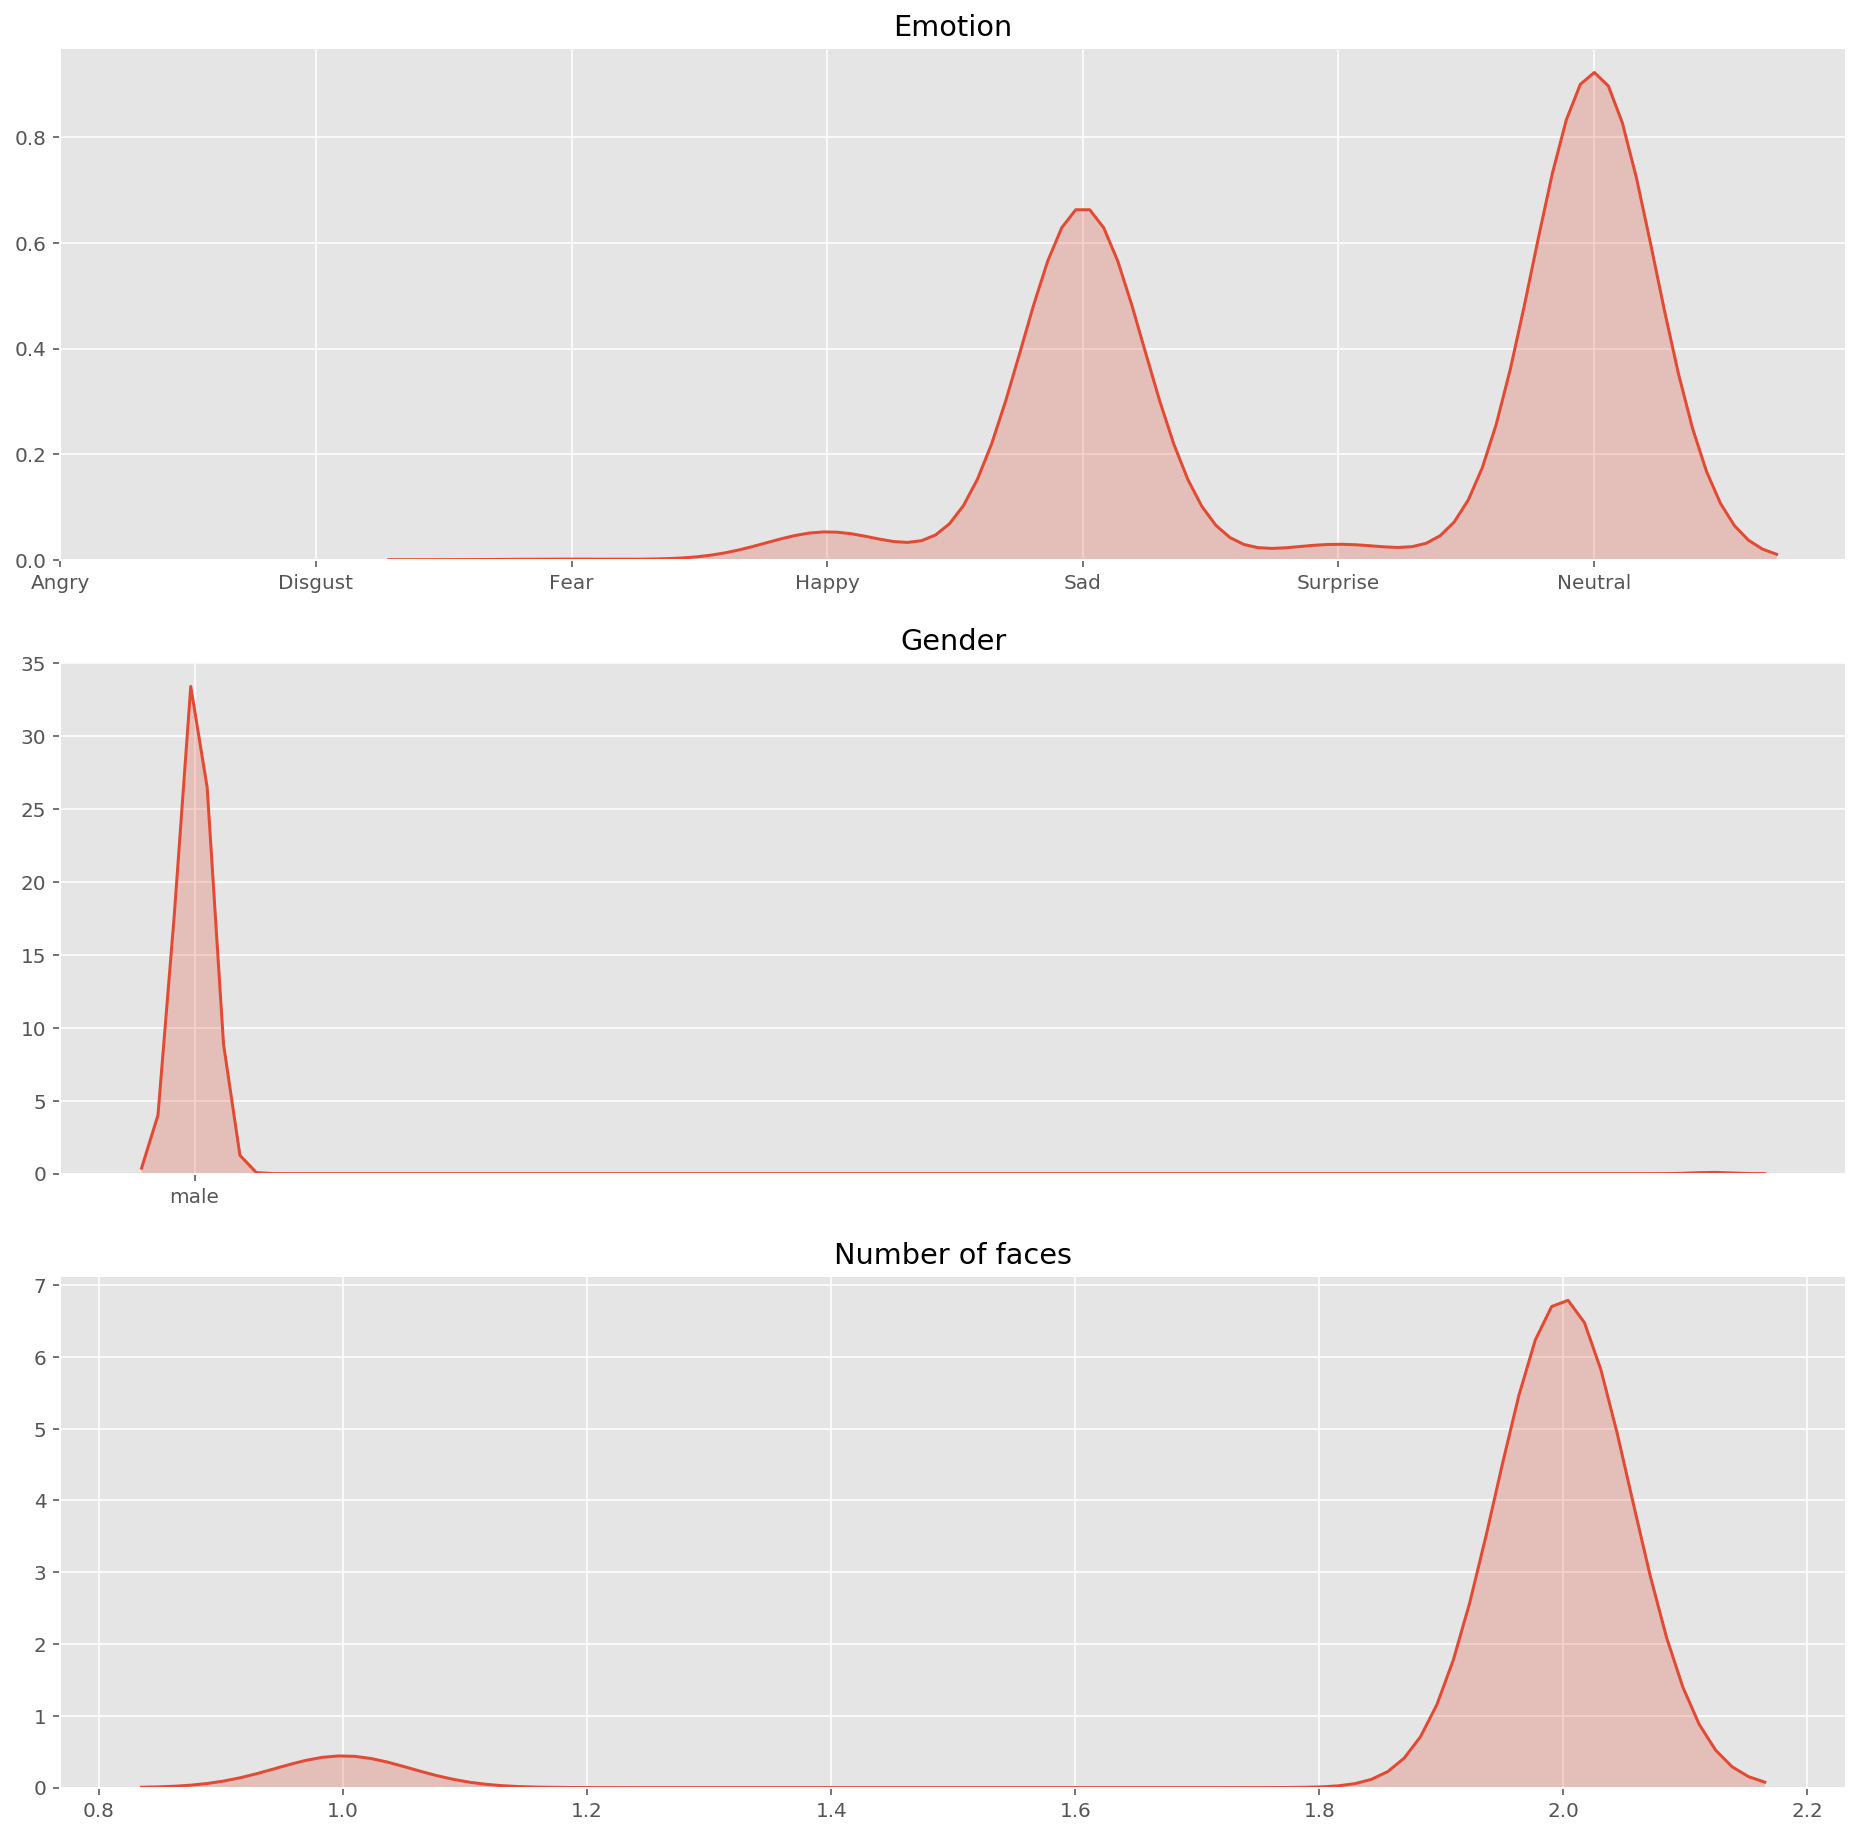

In [7]:
# Convert processed frames to Numpy array
frames = np.array(frames)
print('Video analysis succeed. {} images analyzed'.format(np.shape(frames)))

# Decode all softmax outputs using the argmax function
emotions = [np.argmax(x) for x in total_emotions]
gender = [np.argmax(x) for x in total_gender]

# Generate plots
rcParams['figure.figsize'] = 16, 16

fig = plt.figure()
fig1 = fig.add_subplot(311)
fig2 = fig.add_subplot(312)
fig3 = fig.add_subplot(313)

my_xticks = 'Angry Disgust Fear Happy Sad Surprise Neutral'.split()

ax1 = sns.kdeplot(emotions, shade=True, ax=fig1)
ax1.set(xticks=range(0, 7), xticklabels=my_xticks)
ax1.set_title('Emotion')

ax2 = sns.kdeplot(gender, shade=True, ax=fig2)
ax2.set(xticks=range(0, 1), xticklabels=['male', 'female'])
ax2.set_title('Gender')

ax3 = sns.kdeplot(total_faces, shade=True, ax=fig3)
ax3.set_title('Number of faces')


### Part IV. Video Rendering

In [18]:
# Create video writer
writer = cv2.VideoWriter("my_video.avi", 
                         cv2.VideoWriter_fourcc(*"MJPG"), 
                         40,(frames.shape[2],frames.shape[1]))

for frame in tqdm(frames):
    writer.write(frame.astype('uint8'))
    
writer.release()

100%|██████████| 3113/3113 [00:29<00:00, 104.86it/s]
